In [2]:
#Simple 2D Code for visualizing Compressible Hydrodynamics (Flux Conserving)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
outdir = r"C:\Users\maxri\PyFluid\gifs"

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\maxri\AppData\Local\Temp\ipykernel_3552\4173224496.py:93: RuntimeWarning: invalid value encountered in sqrt
  cs = np.sqrt(self.gamma * safe_divide(self.pressure, self.rho));
C:\Users\maxri\AppData\Local\Temp\ipykernel_3552\4173224496.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(b) > eps, a/b, 0.0)
100%|██████████| 1000/1000 [00:00<00:00, 1080.54it/s]


0.00000


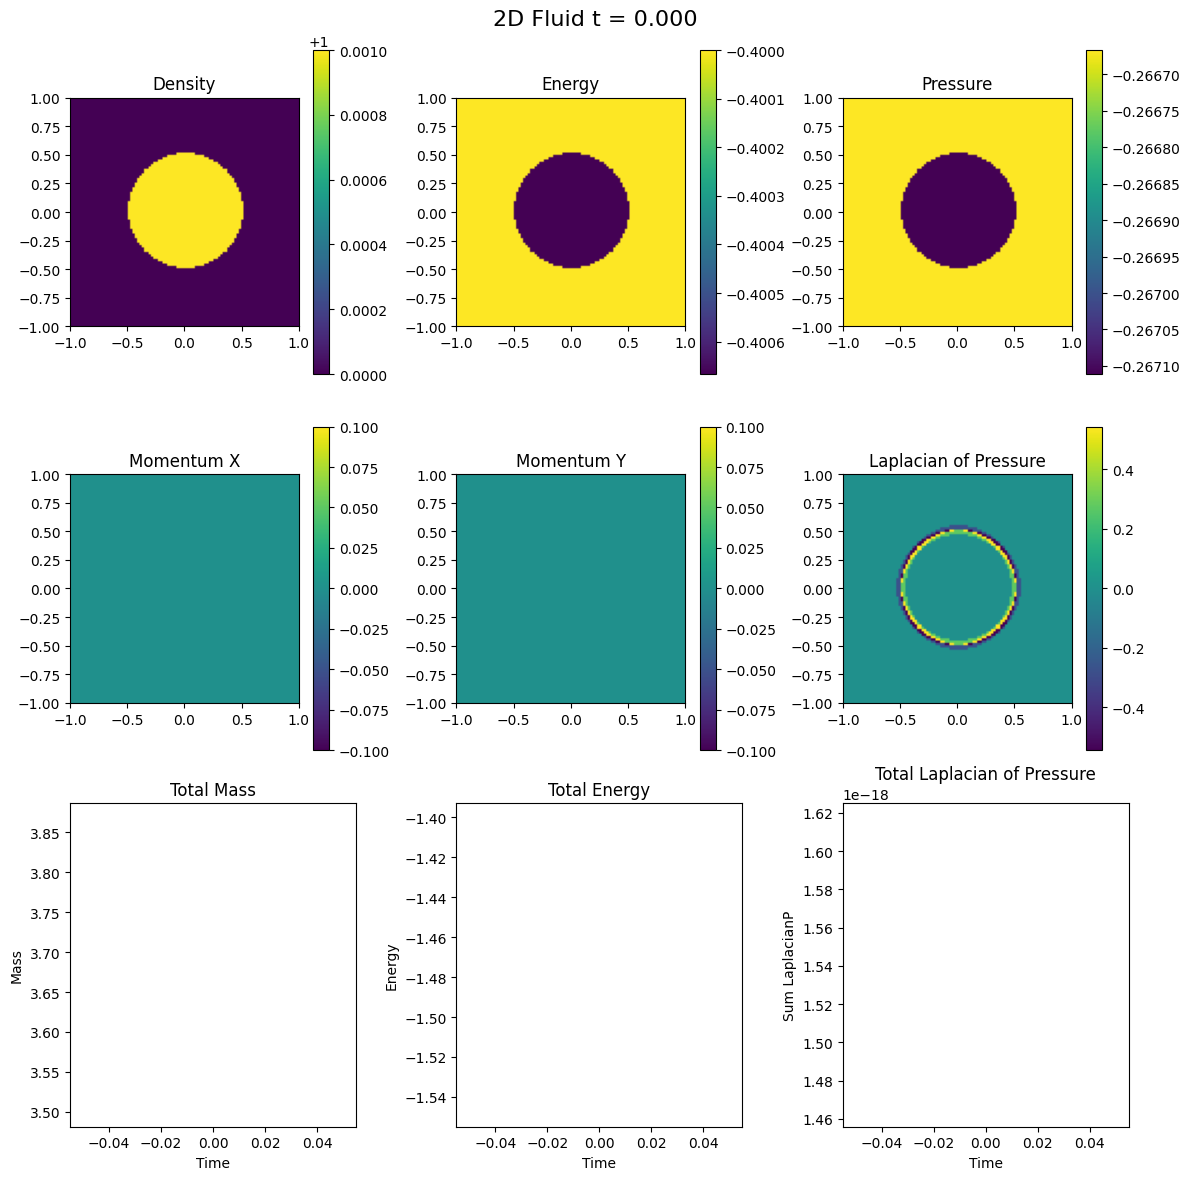

In [6]:
def safe_divide(a,b,eps=1e-10):
   return np.where(np.abs(b) > eps, a/b, 0.0)

class Fluid2D:
    def __init__(self, x0,x1, nx,ici,bci,Nsteps):
        Nsteps = int(Nsteps)
        #Initialize Grid
        self.x0, self.x1 = x0,x1
        self.L = self.x1 - self.x0
        self.nx = nx
        self.x = np.linspace(x0, x1, nx,endpoint=False);
        self.xg,self.yg = np.meshgrid(self.x, self.x);
        self.dx,self.dy =  self.xg[0,1]-self.xg[0,0],self.yg[1,0]-self.yg[0,0];
        self.rg = np.sqrt(self.xg**2 + self.yg**2);
        #initialize conserved variables and pressure
        self.rho = np.zeros_like(self.xg)   
        self.momentum = np.zeros((2,)+self.xg.shape)
        self.vel = np.zeros((2,)+self.xg.shape)
        self.energy = np.zeros_like(self.xg)
        self.pressure = np.zeros_like(self.xg)

        self.gamma = 5/3; #Hardcoded Gamma
        self.ng = 2; #Hardcoded Number of Ghost Cells

        self.Li = self.x[-self.ng] - self.x[self.ng] #Length of Interior Domain

        #store Initial Condition Index and Boundary Condition Index
        self.bci = bci; 
        self.ici = ici

        self.gmaskv = np.zeros((2,) + self.xg.shape);
        self.gmaskv[1,:self.ng,:] = -1; self.gmaskv[1,-self.ng:,:] = 1;
        self.gmaskv[0,:, :self.ng] = -1; self.gmaskv[0,:, -self.ng:] = 1;
        self.gmaskc = np.linalg.norm(self.gmaskv, axis=0)**2
        self.gmask = self.gmaskc != 0 #Ghost cell Mask
        self.imask = ~self.gmask
       
        self.Nint = len(self.xg[self.imask])
        self.nxi = nx - 2*self.ng;

        #initialize fluxes
        self.fluxx = np.zeros((4,)+self.xg.shape)
        self.fluxy = np.zeros((4,)+self.xg.shape)
        #initialize solution vector
        self.uvec= np.zeros((4,)+self.xg.shape)
        self.uvecs = np.zeros((Nsteps, 4) + self.xg.shape)
        self.pressures = np.zeros((Nsteps,) + self.xg.shape); self.gradP = np.zeros((2,) + self.xg.shape)
        self.gradPs = np.zeros((Nsteps,2,) + self.xg.shape)
        self.ts = np.zeros(Nsteps);
        self.dts = np.zeros(Nsteps); self.dt = 0;
        #Apply initial conditions
        self.apply_ics()
        #Copy into solution vector and 
        self.copy_forwards()
        #Initialize time and gradP diagnostic
        self.calc_gradP()
        self.t = 0.0
        self.step = 0
        self.cfl = 0.9;
        self.Nsteps = Nsteps
        
        

    def copy_forwards(self):
        self.uvec[0] = self.rho
        self.uvec[1:3] = self.momentum
        self.uvec[3] = self.energy
    def copy_backwards(self):
        self.rho = self.uvec[0]
        self.momentum = self.uvec[1:3]
        self.energy = self.uvec[3]
    def closure_ideal(self):
        # Ideal gas law closure
        
        self.vel = safe_divide(self.momentum,self.rho)
        self.pressure = (self.gamma - 1) * (self.energy - 0.5*safe_divide(np.linalg.norm(self.momentum, axis=0)**2,self.rho));

    def calc_gradP(self):
        self.gradP[:, :,:] = np.gradient(self.pressure, self.dx)
        self.gradP[:,self.gmask]*=0.0

    def compute_LLF_and_update(self):
        # calculate fluxes
        self.copy_backwards()
        self.fluxx[0] = self.momentum[0];
        self.fluxx[1] = (self.vel[0]**2)*self.rho + self.pressure;
        self.fluxx[2] = self.rho*self.vel[0]*self.vel[1];
        self.fluxx[3] = (self.energy + self.pressure)*self.vel[0];
        self.fluxy[0] = self.momentum[1];
        self.fluxy[1] = self.rho*self.vel[0]*self.vel[1];  
        self.fluxy[2] = (self.vel[1]**2)*self.rho + self.pressure;
        self.fluxy[3] = (self.energy + self.pressure)*self.vel[1];
        cs = np.sqrt(self.gamma * safe_divide(self.pressure, self.rho));
        lam = np.abs(self.vel + cs)
        alpx = np.max([lam[0,:,0:-1],lam[0,:,1:]],axis=0) 
        alpy = np.max([lam[1,0:-1,:],lam[1,1:,:]],axis=0)
        self.dt = self.cfl * self.dx * np.min(safe_divide(1,alpx[self.ng:-self.ng, self.ng-1: -(self.ng)] + alpy[self.ng-1:-(self.ng), self.ng: -(self.ng)]))
        fluxx_cc = 0.5*(self.fluxx[:,:,0:-1] + self.fluxx[:,:,1:]) - 0.5*alpx*(self.uvec[:,:,1:] - self.uvec[:,:,0:-1])
        fluxy_cc = 0.5*(self.fluxy[:,0:-1,:] + self.fluxy[:,1:,:]) - 0.5*alpy*(self.uvec[:,1:,:] - self.uvec[:,0:-1,:])
        delx = fluxx_cc[:,:, self.ng: -(self.ng-1)] - fluxx_cc[:,:, self.ng-1: -(self.ng)]
        dely = fluxy_cc[:,self.ng: -(self.ng-1), :] - fluxy_cc[:,self.ng-1: -(self.ng), :]
        self.uvec[:,self.ng:-self.ng,self.ng:-self.ng] -= (self.dt / self.dx) * (delx[:,self.ng:-self.ng,:] + dely[:,:,self.ng:-self.ng])

    def apply_ics(self):
       self.rhob = 1;self.rhoamp = 1e-3; self.pres0 = 1.0;
       self.cs0 = np.sqrt(self.gamma * self.pres0 / self.rhob);
       if self.ici == 0 or self.ici ==1: #Central Shock
          rsourc = 0.5;
          self.rho[self.imask]+=  self.rhob;
          self.pressure[self.imask] += self.pres0;
          if self.ici == 0:
            self.icname = "Circ.Shock"
            rmask =  (self.rg <= rsourc) & self.imask
          elif self.ici ==1:
            self.icname = "Sq.Shock"
            rmask = (self.xg >=-rsourc) & (self.xg <= rsourc) & (self.yg >=-rsourc) & (self.yg <= rsourc) &self.imask
          self.rho[rmask] += self.rhoamp;
          self.pressure[rmask] += self.rhoamp * self.cs0**2;
          self.momentum[:,rmask] = 0.0
       elif self.ici ==2: #Wave I.C.
           self.icname = "Wave"
           kx = 2.0*np.pi/(self.Li); ky = -2.0*np.pi/(self.Li);
           k = np.sqrt(kx**2 + ky**2);
           self.rho[self.imask] += self.rhob;
           self.pressure[self.imask] += self.pres0;
           self.rho[self.imask] += self.rhoamp * np.sin(kx*self.xg[self.imask]) * np.sin(ky*self.yg[self.imask])    
           self.momentum[0,self.imask] += self.rhoamp * cs0 *(kx/k) * np.sin(kx*self.xg[self.imask]) * np.sin(ky*self.yg[self.imask])
           self.momentum[1,self.imask] += self.rhoamp * cs0*(ky/k) * np.sin(kx*self.xg[self.imask]) * np.sin(ky*self.yg[self.imask])
           self.pressure[self.imask] += cs2*self.rhoamp * np.sin(kx*self.xg[self.imask]) * np.sin(ky*self.yg[self.imask]);
       elif self.ici ==3: #Stationary Vortex I.C.
           self.icname = "Vortex";
           kx = 2.0*np.pi/(self.Li); ky = 2.0*np.pi/(self.Li);
           k = np.sqrt(kx**2 + ky**2);
           self.rho[self.imask] += self.rhob;
           self.pressure[self.imask] += self.pres0;
           self.momentum[0, self.imask] += self.rhoamp * cs0 *(kx/k) * np.sin(kx*self.xg[self.imask]) * np.cos(ky*self.yg[self.imask])
           self.momentum[1, self.imask] += -self.rhoamp * cs0 *(kx/k) * np.cos(kx*self.xg[self.imask]) * np.sin(ky*self.yg[self.imask])
           self.pressure[self.imask] += (self.rho/4)* (cos(kx*self.xg[self.imask])**2 + cos(ky*self.yg[self.imask])**2);

       
       self.apply_bcs()
       #initial energy
       self.energy = (self.pressure)*(1/self.gamma-1) + 0.5*safe_divide(np.linalg.norm(self.momentum, axis=0)**2,self.rho);  
       #Apply boundary conditions
       self.apply_bcs()
       #Apply closure
       self.closure_ideal()

    def apply_bcs(self):
       if np.any(self.bci == 0): #Periodic B.C. Present
          for arr in (self.rho,self.energy,*self.momentum):
             if self.bci[0] == 0: #LHS Periodic
                arr[:,:self.ng] = arr[:, -2*self.ng:-self.ng] 
             if self.bci[1] == 0:  #RHS Periodic
                arr[:,-self.ng:] = arr[:,self.ng:2*self.ng]
             if self.bci[2] == 0:  #BOTTOM Periodic
                arr[:self.ng,:] = arr[-2*self.ng:-self.ng,:]
             if self.bci[3] == 0:  #TOP Periodic
                arr[-self.ng:,:] = arr[self.ng:2*self.ng,:]
       if np.any(self.bci== 1): #Outflow B.C. Present
          for arr in (self.rho,self.energy,*self.momentum):
             if self.bci[0] == 1: #LHS Outflow
                arr[:,:self.ng] = arr[:,self.ng:2*self.ng]
             if self.bci[1] == 1:  #RHS Outflow
                arr[:,-self.ng:] = arr[:,-2*self.ng:-self.ng]
             if self.bci[2] == 1:  #BOTTOM Outflow
                arr[:self.ng,:] = arr[self.ng:2*self.ng,:]
             if self.bci[3] == 1:  #TOP Outflow
                arr[-self.ng:,:] = arr[-2*self.ng:-self.ng,:]
       if np.any(self.bci == 2): #Reflective B.C. Present
            if self.bci[0] == 2: #LHS Reflection
               self.rho[:,:self.ng] = self.rho[:,self.ng:2*self.ng]
               self.energy[:,:self.ng] = self.energy[:,self.ng:2*self.ng]
               self.momentum[:, :, :self.ng] = self.momentum[:, :,self.ng:2*self.ng]
               self.momentum[0,:,:self.ng] *= -1.0   
            if self.bci[1] == 2: #RHS Reflection
               self.rho[:,-self.ng:] = self.rho[:,-2*self.ng:-self.ng]
               self.energy[:,-self.ng:] = self.energy[:,-2*self.ng:-self.ng]
               self.momentum[:,:,-self.ng:] = self.momentum[:,:,-2*self.ng:-self.ng]
               self.momentum[0,:,-self.ng:] *= -1.0
            if self.bci[2] == 2: #BOTTOM Reflection
               self.rho[:self.ng,:] = self.rho[-2*self.ng:-self.ng,:]
               self.energy[:self.ng,:] = self.energy[-2*self.ng:-self.ng,:]
               self.momentum[:, :self.ng,:] = self.momentum[:, -2*self.ng:-self.ng,:]
               self.momentum[1,:self.ng,:] *= -1.0
            if self.bci[3] == 2: #TOP Reflection
               self.rho[-self.ng:,:] = self.rho[-2*self.ng:-self.ng,:]
               self.energy[-self.ng:,:] = self.energy[-2*self.ng:-self.ng,:]
               self.momentum[:, -self.ng:,:] = self.momentum[:, -2*self.ng:-self.ng,:]
               self.momentum[1,-self.ng:,:] *= -1.0
       if np.any((self.bci != 0) & (self.bci != 1) & (self.bci != 2)):
          raise ValueError("Invalid B.C. Key")

    def plot_all(self,it):
      fig, axs = plt.subplots(3,3,figsize=(12, 12))
      fig.suptitle(f"2D Fluid t = {self.ts[it]:.3f}", fontsize=16)
      im0 = axs[0, 0].imshow(self.uvecs[it, 0], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[0, 0].set_title('Density')
      fig.colorbar(im0, ax=axs[0, 0])

      im1 = axs[0, 1].imshow(self.uvecs[it, 3], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[0, 1].set_title('Energy')
      fig.colorbar(im1, ax=axs[0, 1])

      im2 = axs[1, 0].imshow(self.uvecs[it, 1], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1, 0].set_title('Momentum X')
      fig.colorbar(im2, ax=axs[1, 0])

      im3 = axs[1, 1].imshow(self.uvecs[it, 2], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1, 1].set_title('Momentum Y')
      fig.colorbar(im3, ax=axs[1, 1])

      im4 = axs[0,2].imshow(self.pressures[it], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[0, 2].set_title('Pressure')
      fig.colorbar(im4, ax=axs[0, 2])

      im5 = axs[1,2].imshow(self.lapPs[it], extent=(self.x0, self.x1, self.x0, self.x1), origin='lower')
      axs[1, 2].set_title('Laplacian of Pressure')
      fig.colorbar(im5, ax=axs[1, 2])

      axs[2,0].plot(self.ts, self.mtots)
      axs[2,0].set_title('Total Mass')
      axs[2,0].set_xlabel('Time')
      axs[2,0].set_ylabel('Mass')

      axs[2,1].plot(self.ts, self.etots)
      axs[2,1].set_title('Total Energy')
      axs[2,1].set_xlabel('Time')
      axs[2,1].set_ylabel('Energy')

      axs[2,2].plot(self.ts, self.laptots)
      axs[2,2].set_title('Total Laplacian of Pressure')
      axs[2,2].set_xlabel('Time')
      axs[2,2].set_ylabel('Sum LaplacianP')

      plt.tight_layout()
      #plt.show()

    def run_and_store(self):
        for step in tqdm(range(self.Nsteps)):      
            self.pressures[step] = self.pressure
            self.uvecs[step] = self.uvec
            self.ts[step] = self.t
            self.dts[step] = self.dt


            self.compute_LLF_and_update()
            self.apply_bcs()
            self.closure_ideal()

            self.t += self.dt
            self.step += 1

        self.postprocess()   

    def postprocess(self):
        self.mtots = np.sum(self.uvecs[:,0,:]*self.imask,axis = (1,2)) * self.dx * self.dx
        self.etots = np.sum(self.uvecs[:,3,:]*self.imask,axis = (1,2)) * self.dx * self.dx
        self.gradPs = np.gradient(self.pressures, self.dx,axis=(1,2))
        P_xx, bad = np.gradient(self.gradPs[0],self.dx, axis=(1,2))
        bad,P_yy = np.gradient(self.gradPs[1],self.dx, axis=(1,2))
        self.lapPs = (P_xx + P_yy) 
        self.laptots = np.sum(self.lapPs, axis=(1,2)) * self.dx * self.dx


x0t = -1.0; x1t = 1.0;  nxt = 99;
Nsteps = 1e3
#IC Key
#[0 = Central Circular Shock, 1 = Central Square Shock, 2 = Wave, 3 = Vortex]
ici = 0
#BC Key
#[0 = Periodic, 1 = Outflow, 2 = Reflective  ]
# LHS, RHS, BOTTOM, TOP
bci = np.array([0,0,0,0])
state = Fluid2D(x0t, x1t, nxt, ici, bci,Nsteps)
state.run_and_store()

it = 0
state.plot_all(it)
print(f'{state.dts.mean():.5f}')

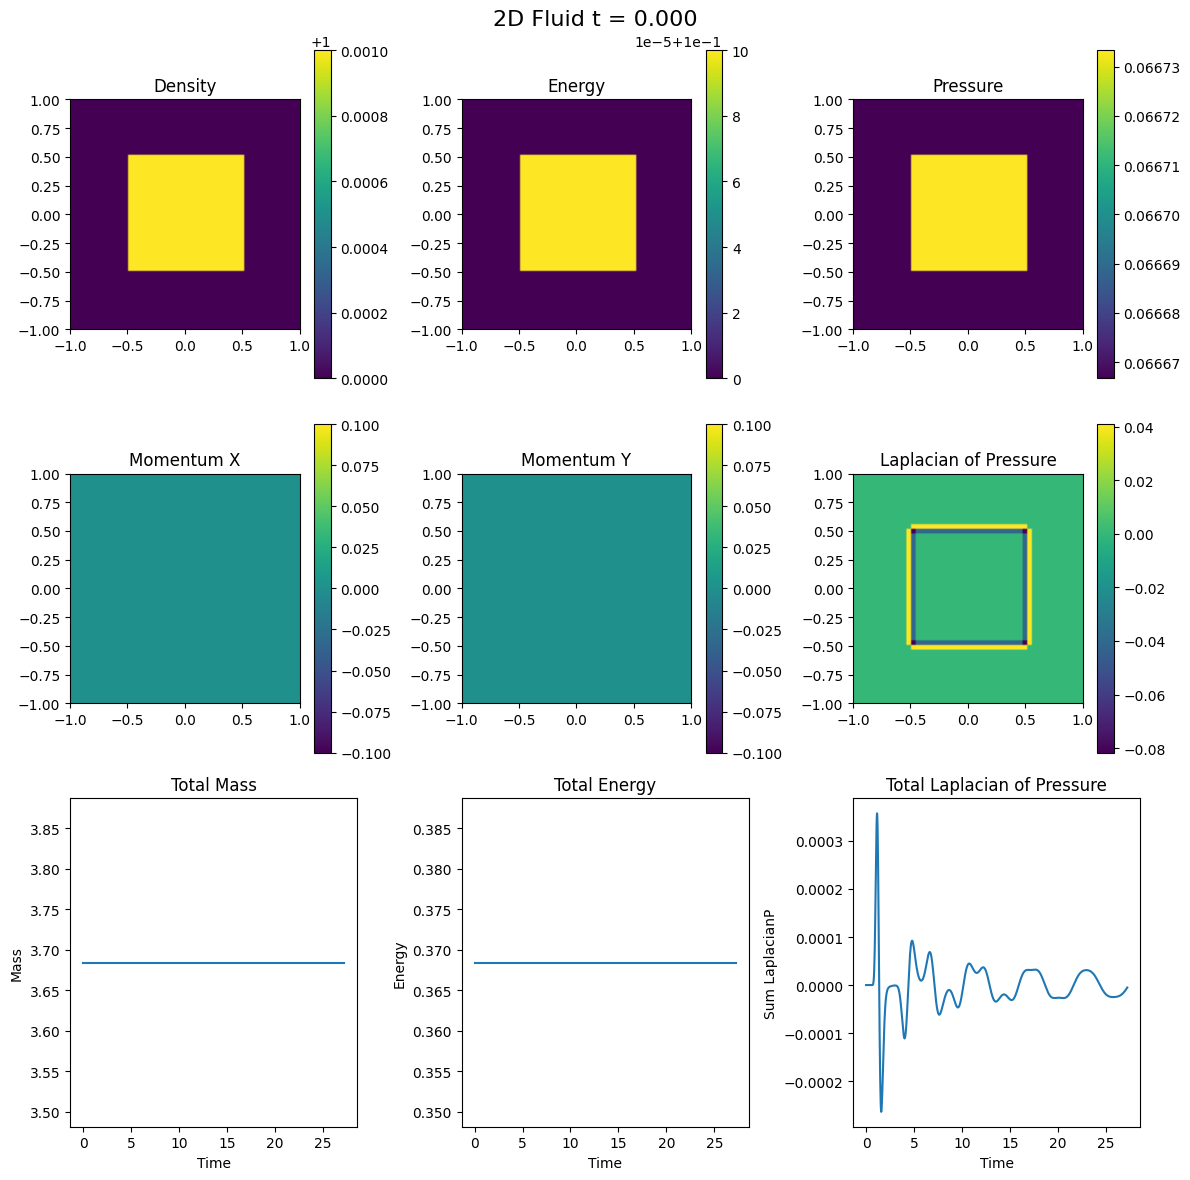

In [181]:
it = 0
state.plot_all(it)

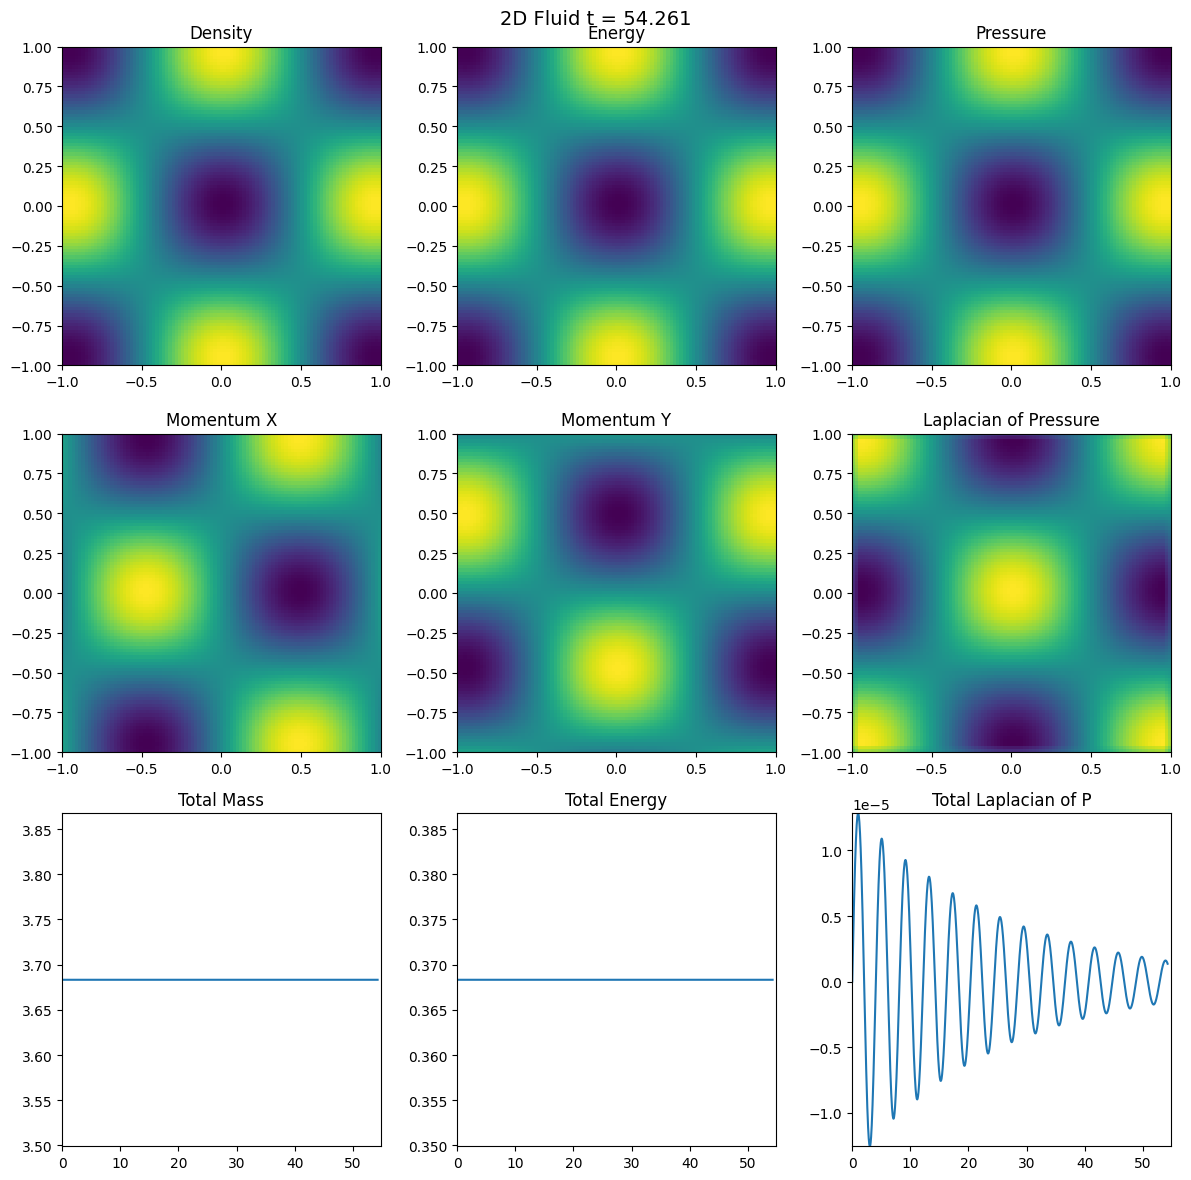

In [113]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
frames=200
framestep = 10;
framei = np.arange(frames)*framestep

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
title = fig.suptitle(f"2D Fluid t = {state.ts[0]:.3f}", fontsize=14)
# Initial plots (empty)

cutp = int(0.4*state.Nsteps)
im1 = axs[0,0].imshow(np.zeros_like(state.uvecs[0, 0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,0].min(),vmax = state.uvecs[cutp:,0].max(), origin='lower')
im2 = axs[0,1].imshow(np.zeros_like(state.uvecs[0, 3]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,3].min(),vmax = state.uvecs[cutp:,3].max(), origin='lower')
im3 = axs[0,2].imshow(np.zeros_like(state.pressures[0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.pressures[cutp:].min(),vmax = state.pressures[cutp:].max(), origin='lower')
im4 = axs[1,0].imshow(np.zeros_like(state.uvecs[0,1]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,1].min(),vmax = state.uvecs[cutp:,1].max(), origin='lower')
im5 = axs[1,1].imshow(np.zeros_like(state.uvecs[0,2]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[cutp:,2].min(),vmax = state.uvecs[cutp:,2].max(), origin='lower')
im6 = axs[1,2].imshow(np.zeros_like(state.lapPs[0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.lapPs[cutp:].min(),vmax = state.lapPs[cutp:].max(), origin='lower')
heatmaps = [im1, im2, im3, im4, im5, im6]

line1 = axs[2,0].plot([], [])[0]
line2 = axs[2,1].plot([], [])[0]
line3 = axs[2,2].plot([], [])[0]
axs[2,0].set_ylim(state.mtots.min(), state.mtots.max())
axs[2,1].set_ylim(state.etots.min(), state.etots.max())
axs[2,2].set_ylim(state.laptots.min(), state.laptots.max()) 
for j in range(3):
   axs[2,j].set_xlim(-state.ts[1], state.ts[framei[-1]]*1.01)
lines = [line1, line2, line3]
plt.tight_layout()
def init():
   titles = [
      "Density",
      "Energy",
      "Pressure",
      "Momentum X",
      "Momentum Y",
      "Laplacian of Pressure",
      "Total Mass",
      "Total Energy",
      "Total Laplacian of P"
   ]

   
   for idx, ax in enumerate(axs.flat):
      ax.set_title(titles[idx])
   for line in lines:
      line.set_data([], [])
   return heatmaps + lines

def animate(frame):
   # Top 6 heatmaps (example: density, energy, momentum_x, momentum_y, pressure, laplacian_pressure)
   heatmaps[0].set_data(state.uvecs[frame, 0])
   heatmaps[1].set_data(state.uvecs[frame, 3])
   heatmaps[2].set_data(state.pressures[frame])
   heatmaps[3].set_data(state.uvecs[frame, 1])
   heatmaps[4].set_data(state.uvecs[frame, 2])
   heatmaps[5].set_data(state.lapPs[frame])
   heatmaps[0].set_clim(vmin=state.uvecs[frame,0].min(), vmax=state.uvecs[frame,0].max())
   heatmaps[1].set_clim(vmin=state.uvecs[frame,3].min(), vmax=state.uvecs[frame,3].max())
   heatmaps[2].set_clim(vmin=state.pressures[frame].min(), vmax=state.pressures[frame].max())
   heatmaps[3].set_clim(vmin=state.uvecs[frame,1].min(), vmax=state.uvecs[frame,1].max())
   heatmaps[4].set_clim(vmin=state.uvecs[frame,2].min(), vmax=state.uvecs[frame,2].max())
   heatmaps[5].set_clim(vmin=state.lapPs[frame].min(), vmax=state.lapPs[frame].max())  

   # Bottom 3 lines (cumulative up to current frame)
   lines[0].set_data(state.ts[:frame+1], state.mtots[:frame+1])
   lines[1].set_data(state.ts[:frame+1], state.etots[:frame+1])
   lines[2].set_data(state.ts[:frame+1], state.laptots[:frame+1])
   title.set_text(f"2D Fluid t = {state.ts[frame]:.3f}")

   return heatmaps + lines

anim = FuncAnimation(fig, animate, frames=framei, init_func=init, blit=True, interval=10*state.dts[0:framei[-1]].mean())
#HTML(anim.to_jshtml())
anim.save(f"{outdir}/{state.icname}_anim.mp4", writer="ffmpeg", fps=25, dpi=200)

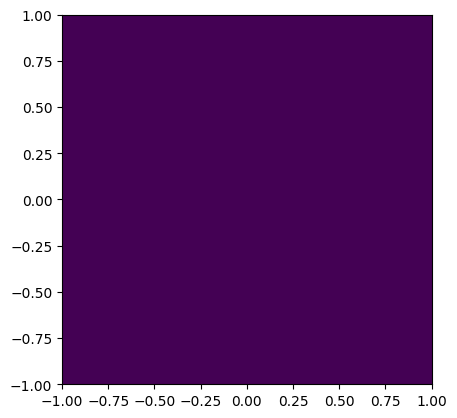

In [24]:
plt.imshow(np.zeros_like(state.uvecs[0,0]), extent=(state.x0, state.x1, state.x0, state.x1),vmin = state.uvecs[0].min(),vmax = state.uvecs[0].max(), origin='lower')

In [19]:
state.uvecs[0,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(100, 100))